### Preprocessing notebook

The data comes from the following link: https://www.consumerfinance.gov/credit-cards/agreements/

The Consumer Financial Protection Bureau (CFPB) collects credit card agreements from creditors on a quarterly basis and posts them at the link above. The CFPB organizes the data by putting each participating company in a directory and then collecting all the statements in a directory for each company. For Q4 of 2018 there are 652 companies and each company has on average 2-4 agreements. 

The purpose of this repo/notebook will be to analyze these documents and label passages within the document so that a potential customer can read it faster and with greater comprehension. For most people contract documents are not fun to read because they are usually written in complex legal jargon and the style of writing is purposely dry so as to spell out worst-case scenarios. That said it is important to understand what you or your business is getting into before signing any sort of agreement. Because it takes a certain type of expertise to understand these documents I feel it would be interesting to see if we can leverage natural language techniques to tag this these documents 

In [5]:
from utils.process_data import Process

In [6]:
import os

DATA_PATH = './data/cc_2018/'
files = [f for f in os.listdir(DATA_PATH)]
data_init = Process(files, DATA_PATH, 'pdf-output-2.pkl')
OVERWRITE = True

In [7]:
custom_stopwords = ['aaa']

process_val = {'stopwords':'english',
               'custom_sw':custom_stopwords,
               'stemmer':'yes',
               'ngrams':'bigrams'}

temp_ = data_init.remove_lines(OVERWRITE, data_init, **process_val)

cleaning pdf files...
now preprocessing the data...
dumping file to pkl...
done


##### Sizing of the features fed into the model - how to split - should I split on \n\n or \n?

In [8]:
# gs_params = {
#     'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     'tfidf__max_df': (0.4, 0.5, 0.6,0.7),
#     'tfidf__min_df': (5,10,15,20)
#     'tfidf__use_idf': (True, False),
#     'clf__alpha': (1e-2, 1e-3),
# }

# data_init.gridsearch(**gs_params)

In [12]:
params = {'vectorizor': 'tfidf',
          'max_df': .5,
          'min_df': 100,
          'max_features':None 
         }

tfidf = data_init.vectorize(**params)

tfidf

loading data...
loaded...
applying tfidf


<48451x3234 sparse matrix of type '<class 'numpy.float64'>'
	with 1517921 stored elements in Compressed Sparse Row format>

In [13]:
from sklearn.decomposition import NMF
import pickle

if os.path.exists('./data/nmf-output.pkl') == False:
    print('processing nmf...')
    kmin, kmax = 4,15
    
    print(f'calculating nmf for k {kmin} to {kmax}...')
    d = {}
    for k in range(kmin,kmax+1):
        model = NMF(init='nndsvd', n_components=k) 
        d[k] = model.fit_transform(tfidf), model.components_ #collect W & H factors
    
    print('dumping file to pkl...')
    output = open('./data/nmf-output.pkl', 'wb')
    pickle.dump(d, output)
    output.close()
    print('done')
    
else:
    print('file exists, loading data...')
    
    pkl_file = open('./data/nmf-output.pkl', 'rb')
    d = pickle.load(pkl_file)
    pkl_file.close()
    
    print('loaded...')

processing nmf...
calculating nmf for k 4 to 15...
dumping file to pkl...
done


In [16]:
import pandas as pd

df_ = pd.concat([temp_[k] for k in temp_.keys()],axis=0).reset_index().drop(['index'],axis=1)

l = [df_[0].iloc[x].split(", ") for x in range(652)]

In [33]:
data_ = data_init._iterate()

In [45]:
from itertools import chain

combined_ = [i for i in chain.from_iterable([data_[i] for i in data_.keys()])]

In [48]:
data = pd.DataFrame(combined_)

In [17]:
df_.head()

,0
0,"credit_card, card_applic, applic_disclosur, cr..."
1,"ibmsecu_ibm, ibm_southeast, southeast_employe,..."
2,"credit_card, card_applic, applic_disclosur, cr..."
3,"import_credit, credit_card, card_disclosur, di..."
4,"interest_rate, rate_interest, interest_charg, ..."


In [19]:
import gensim
import pandas as pd

if os.path.exists('./data/w2v-model.bin') == False:
    print('preprocessing text data for w2v model')
    #w2v_raw = data_init.preprocess(temp_['USE Credit Union'], **process_val)
    
    #processed = {k: data_init.preprocess(temp_[k], **process_val) for k in temp_.keys()}
    
    #processed = data_init.remove_lines(OVERWRITE, data_init, **process_val)
    
    w2v_raw = l
    
    #w2v_raw = pd.concat([processed[k] for k in processed.keys()],axis=0).reset_index().drop(['index'],axis=1)

    print('making w2v model')
    w2v_m = gensim.models.Word2Vec(w2v_raw, size=500, min_count=20, sg=1)

    print(f'word2vec model has {len(w2v_m.wv.vocab)} terms')
    w2v_m.save('./data/w2v-model.bin')
    
else:
    print('file exists...')
    w2v_m = gensim.models.Word2Vec.load('./data/w2v-model.bin')
    print(f'word2vec model has {len(w2v_m.wv.vocab)} terms')

preprocessing text data for w2v model
making w2v model
word2vec model has 374 terms


In [20]:
from sklearn.externals import joblib

(tfidf_,terms) = joblib.load('./data/tfidf-output.pkl')

In [23]:
f2t_m = gensim.models.Word2Vec.load('./data/f2t-model.bin')

In [24]:
from utils.topic_model import calculate_coherence, top_term

k_values, coherences = [],[]
for k in range(4,15):
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = [top_term(terms, d[k][0], topic_index, 10) for topic_index in range(k)]

    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(f2t_m, term_rankings)) 

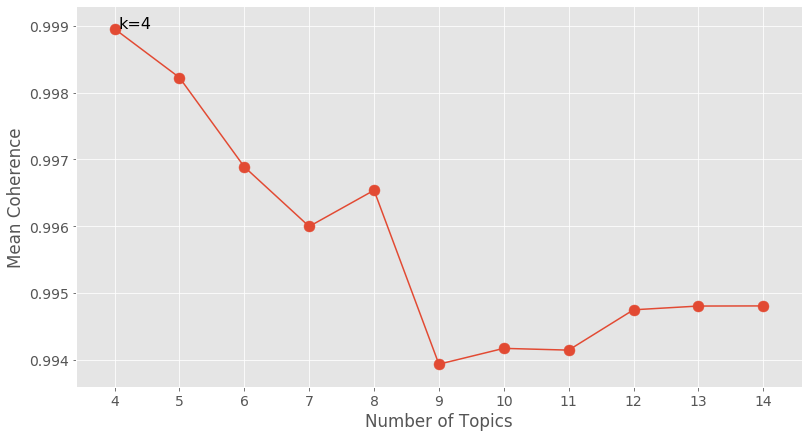

In [25]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14})

fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot(k_values, coherences)
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter(k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [65]:
p = Process(files, DATA_PATH, '-output.pkl')._iterate()

In [92]:
df_1 = pd.concat([pd.DataFrame([p[k][s] for s in range(len(p[k]))]) for k in p.keys()],axis=0)

In [93]:
import pandas as pd

#processed = {k: data_init.preprocess(temp_[k], **process_val) for k in temp_.keys()}
#df_1 = pd.concat([p[k] for k in p.keys()],axis=0).reset_index().drop(['index'],axis=1)

In [94]:
#p.keys()

In [104]:
#df_1[0].head()

In [60]:
from utils.topic_model import get_top_snippets

k = 8
W = d[k][0]
H = d[k][1]


sentences = [headline[0:min(len(headline),100)] for headline in data[0]]
descriptors = [top_term(terms, H, topic_index, 10) for topic_index in range(k)]


hand_label = {}
for i in range(k):
    topic = i
    headlines = 15

    d_ = {i+1: sentences
             for i,sentences in enumerate(get_top_snippets(sentences, W, topic, headlines))
        }
    
    hand_label[i] = pd.DataFrame.from_dict(d_, orient='index').rename(columns={0:'ground_truth',1:'NMF categorized'})
    temp_ = pd.DataFrame.from_dict(d_, orient='index').rename(columns={0:'ground_truth',1:'NMF categorized'})


    print('#''='*30)
    print(f'top terms for topic {topic}')
    print(descriptors[topic])

    print('='*50)
    gt_top = temp_['ground_truth'].value_counts().index[0]
    print(f'top ground truth label: {gt_top}')

    print('='*50)
    print(f'ground truth v. top headlines for topic {topic}')
    print(temp_)
    print('')

#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
top terms for topic 0
['payment', 'minimum', 'minimum_payment', 'due', 'late', 'payment_due', 'late_payment', 'return', 'statement', 'return_payment']
top ground truth label: Payments  
 
ground truth v. top headlines for topic 0
           ground_truth
1              PAYMENTS
2              Payments
3             PAYMENT $
4              Payments
5          PAYMENTS\n\n
6         Payments  \n 
7   Your payment. \n\n 
8   About your payments
9         Payments  \n 
10        Payments  \n 
11  PAYMENTS.   \n\n   
12        Payments  \n 
13            PAYMENT $
14  About your payments
15        Payments  \n 

#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
top terms for topic 1
['apr', 'rate', 'prime', 'prime_rate', 'base', 'market_base', 'vari_market', 'apr_vari', 'base_prime', 'vari']
top ground truth label: 26.24% 
This APR will vary with the market based on the Prime Rate. 
ground truth v. top headlines for top

##### Bootstrap - label

In [92]:
#create a label column right here 

labels = ['payment','rate','agreement','error','fee','purchases','interest','credit_tips']

for k in hand_label.keys():
    hand_label[k]['label'] = labels[k]

In [103]:
hand_label[0] = hand_label[0].drop(['new_column'],axis=1)

In [104]:
label = ['label']

hl = pd.concat([hand_label[k] for k in hand_label.keys()],axis=0).reset_index().drop(['index'],axis=1)

In [114]:
#train a classifier

hl.head()

,ground_truth,label
0,PAYMENTS,payment
1,Payments,payment
2,PAYMENT $,payment
3,Payments,payment
4,PAYMENTS\n\n,payment


In [139]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import bigrams,trigrams

def preprocess(text, **kwargs):
        '''
        Basic NLP preprocessor
        -removes stop words
        -n-grams
        -stem
        -simple gensim preprocessor
        '''

        stopwords_ = kwargs.get('stopwords')
        cust_sw = kwargs.get('custom_sw')
        stemmer = kwargs.get('stemmer')
        ngrams = kwargs.get('ngrams')

        text = text.apply(gensim.utils.simple_preprocess, min_len=3)
        
        sw = set(stopwords.words(stopwords_))
        custom_sw = set(cust_sw)

        if stopwords_: text = text.apply(lambda s: [w for w in s if w not in sw]) 

        if custom_sw: text = text.apply(lambda s: [w for w in s if w not in custom_sw])

        if stemmer=='yes': text = text.apply(lambda s: [SnowballStemmer("english", ignore_stopwords=True).stem(w) for w in s])

        if ngrams=='bigrams': 
            text = text.apply(lambda s: ['_'.join(x) for x in nltk.bigrams(s)] + s)

        elif ngrams=='trigrams':
            text = text.apply(lambda s: ['_'.join(x) for x in nltk.trigrams(s)] + s)

        return text

In [149]:
hl['ground_truth'] = preprocess(hl['ground_truth'],**process_val).apply(lambda x:', '.join(map(str, x)))



In [152]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [154]:
tfidf = TfidfVectorizer(max_df=0.5, 
                        min_df=20)

tfidf_ = tfidf.fit_transform(hl['ground_truth'])

In [226]:
print('dumping file to pkl...')
output = open('./data/keras-data.pkl', 'wb')
pickle.dump((tfidf_,hl['label']), output)
output.close()
print('done')
    


#tfidf_,hl['label']) = joblib.dump('./data/keras-data.pkl')

dumping file to pkl...
done


In [156]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc

#roc plot

def roc_plot(fpr, tpr, roc_auc):
    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [157]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

clf = MultinomialNB()

In [159]:
X,y = tfidf_, hl['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

  agreement       0.50      0.33      0.40         3
credit_tips       0.67      0.80      0.73         5
      error       0.22      1.00      0.36         2
        fee       0.00      0.00      0.00         4
   interest       1.00      1.00      1.00         3
    payment       0.00      0.00      0.00         3
  purchases       1.00      1.00      1.00         2
       rate       1.00      1.00      1.00         2

avg / total       0.51      0.58      0.52        24



In [160]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ()

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [166]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 3,
          'loss': 'deviance'}

# Initialize and fit the model.
ens = ensemble.GradientBoostingClassifier(**params)

In [167]:
X,y = tfidf_, hl['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)
ens.fit(X_train,y_train)
y_pred = ens.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

  agreement       0.75      1.00      0.86         3
credit_tips       1.00      0.80      0.89         5
      error       0.22      1.00      0.36         2
        fee       0.00      0.00      0.00         4
   interest       1.00      1.00      1.00         3
    payment       0.00      0.00      0.00         3
  purchases       1.00      1.00      1.00         2
       rate       1.00      1.00      1.00         2

avg / total       0.61      0.67      0.61        24



In [221]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


svc_params ={'kernel':('linear', 'rbf'), 'C':[1, 10]}

rfc_params = {
    'n_estimators': [50, 150, 250, 350, 450],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6, 8]
}


clf1 = GridSearchCV(SVC(probability=True), svc_params)
clf2 = GaussianNB()
rf_model = RandomForestClassifier(random_state=1)
clf3 = GridSearchCV(rf_model, rfc_params, cv=5)


eclf = VotingClassifier(estimators=[('svc', clf1),
                                    ('gnb', clf2),
                                    ('ens',ens),
                                    ('rfc', clf3)], 
                                    voting='soft')

In [222]:
X,y = tfidf_.toarray(), hl['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)
eclf.fit(X_train,y_train)
y_pred = eclf.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

  agreement       0.75      1.00      0.86         3
credit_tips       1.00      0.80      0.89         5
      error       0.00      0.00      0.00         2
        fee       0.00      0.00      0.00         4
   interest       1.00      1.00      1.00         3
    payment       0.33      1.00      0.50         3
  purchases       1.00      1.00      1.00         2
       rate       1.00      1.00      1.00         2

avg / total       0.64      0.71      0.65        24



/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [258]:
text = ['This APR will vary with the market based on the Prime Rate.', 'another sentence']

custom_stopwords = ['aaa']

process_val = {'stopwords':'english',
               'custom_sw':custom_stopwords,
               'stemmer':'yes',
               'ngrams':'bigrams'}

test = preprocess(pd.Series(text), **process_val).apply(lambda x:', '.join(map(str, x)))

In [264]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfVectorizer()

tfidf__ = tfidf.fit_transform(test)

In [322]:
X,y = hl['ground_truth'], hl['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)

In [323]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [324]:
text_clf.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [325]:
y_pred = text_clf.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

  agreement       1.00      0.67      0.80         3
credit_tips       0.83      1.00      0.91         5
      error       1.00      1.00      1.00         2
        fee       1.00      1.00      1.00         4
   interest       1.00      1.00      1.00         3
    payment       1.00      1.00      1.00         3
  purchases       1.00      1.00      1.00         2
       rate       1.00      1.00      1.00         2

avg / total       0.97      0.96      0.96        24



In [340]:
docs_new = ['Billing Rights: This notice tells you about your rights',
            'INTEREST RATES and INTEREST CHARGES',
            'For Credit Card Tips from the Consumer To learn more about factors to consider when applying for or',
            'This APR will vary with the market based on the Prime Rate.'
           ]

docs_new = preprocess(pd.Series(docs_new),**process_val).apply(lambda x:', '.join(map(str, x)))

text_clf.predict(docs_new)

array(['error', 'interest', 'credit_tips', 'rate'], dtype='<U11')

In [341]:
new_init = Process(files, DATA_PATH, 'pdf-output-3.pkl')

new_data = new_init._iterate()

In [347]:
new_data['IBMSECU'][3]

'IMPORTANT CREDIT CARD DISCLOSURES \nThe following disclosure represents important details concerning your credit card. The information about costs of the card are \naccurate as of 01/01/2016. You can contact us toll free at 800.873.5100 or the address above to inquire if any changes \noccurred since the effective date. '

In [ ]:
new_data['121 Financial Credit Union']

In [356]:
for i in new_data['121 Financial Credit Union']:
    a = preprocess(pd.Series(i),**process_val).apply(lambda x:', '.join(map(str, x)))
    print(i[:25], text_clf.predict(a))

PdfHandler.ashx


© CUNA  ['purchases']
APPLICATION AND
SOLICITAT ['error']
Interest Rates and Intere ['interest']
Visa Platinum ['error']
Visa Platinum Rewards
, , ['rate']
Visa Signature
, , , or , ['rate']
APR for Balance Transfers ['purchases']
Visa Platinum Rewards
, , ['rate']
Visa Signature
, , , or , ['rate']
APR for Cash Advances Vis ['purchases']
Visa Platinum Rewards
, , ['rate']
Visa Signature
, , , or , ['rate']
SEE NEXT PAGE for more im ['error']
VISA PLATINUM/VISA PLATIN ['error']
14.40% ['error']
11.24% 12.24% 13.24% 16.2 ['error']
12.24% 13.24% 16.24% 17.2 ['error']
14.40% ['error']
11.24% 12.24% 13.24% 16.2 ['error']
12.24% 13.24% 16.24% 17.2 ['error']
14.40% ['error']
11.24% 12.24% 13.24% 16.2 ['error']
12.24% 13.24% 16.24% 17.2 ['purchases']
Penalty APR and When it A ['rate']
Visa Platinum Rewards ['error']
Visa Signature ['error']
This APR may be applied t ['payment']
How Long Will the Penalty ['rate']
How to Avoid Paying Inter ['purchases']
Your due date is at lea